In [85]:
# Imports 
import sys
from py2neo import neo4j, Graph, Relationship
from py2neo.cypher import CypherWriter
import MySQLdb


In [86]:
# Create MySQL connection
user = "lcdebaca"
password = "qbRUy*uW7bUffBcBUBD7"
database = "starmetrics"

# invoke the connect() function, passing parameters in variables.
db = MySQLdb.connect( user = user, passwd = password, db = database )

# output basic database connection info.
print( db )

cursor = db.cursor( MySQLdb.cursors.DictCursor )
# Print Curser
print(cursor)

<_mysql.connection open to 'localhost' at 2f2b620>


In [87]:
# Test SQL 


# The Following is a Query of the starmetrics database
# It collects the following variables for Purdue University between the 
#years 2008 - 2012:  
#From the employee Table: id, employeeid, uniqueawardnumber, employeeoccupation
#From the occupation Table: occupationalclassification 

# NOTE I LIMIT TO 200 BECAUSE THE REST OF THE NOTEBOOK WONT RUN OTHERWISE 
sql_select = "SElECT employee.employeeid, employee.uniqueawardnumber, employee.occupation_orig, \
occupation.occupationalclassification \
FROM starmetrics.employee \
INNER JOIN starmetrics.occupation ON \
starmetrics.employee.occupation_orig = occupation.occupation_orig \
WHERE starmetrics.employee.university = 'purdue' AND starmetrics.employee.year BETWEEN 2008 AND 2012 LIMIT 200;"

result_count = cursor.execute(sql_select);

# Count the number of rows returned 
print("Found " + str(result_count) + " rows")

# Testing
one = cursor.fetchone()
print(one.keys())
print(one)


# Store the results of the Query in a list
results = cursor.fetchall()


Found 200 rows
['occupationalclassification', 'occupation_orig', 'employeeid', 'uniqueawardnumber']
{'occupationalclassification': 'Undergraduate', 'occupation_orig': 'UNDERGRAD', 'employeeid': '90009387', 'uniqueawardnumber': "'00.500 NONGrant"}


In [ ]:
# I want to test the code without a a ton of cases, so here is my example results list 

results = [
    {'occupationalclassification': 'Undergraduate', 'occupation_orig': 'UNDERGRAD', 'employeeid': '90009387', 'uniqueawardnumber': "'00.500 NONGrant"},
    {'occupationalclassification': 'Undergraduate', 'occupation_orig': 'UNDERGRAD', 'employeeid': '90009387', 'uniqueawardnumber': "'00.500 NONGrant"},
    {'occupationalclassification': 'Graduate Student', 'occupation_orig': 'GRADUATE', 'employeeid': '90027173', 'uniqueawardnumber': '00.070 03-C-NE-PU'},
    {'occupationalclassification': 'Faculty', 'occupation_orig': 'FACULTY', 'employeeid': '90014540', 'uniqueawardnumber': '00.070 03-C-NE-PU'},
    {'occupationalclassification': 'Faculty', 'occupation_orig': 'FACULTY', 'employeeid': '90014540', 'uniqueawardnumber': '00.070 03-C-NE-PU'},

]

In [88]:
# Create connection to the Neo4jsdatabase using defaults
# note, I imported Graph when I imported py2neo
graph_db_test = Graph()
print graph_db_test

#Create the Neo4j Database 
graph_db_test.create()

# Force nodes to have unique employeeids and uniqueawardnumbers
graph_db_test.schema.create_uniqueness_constraint("employeeid", "uniqueawardnumber")


<Graph uri=u'http://localhost:7474/db/data/'>


ConstraintViolationException: Label 'employeeid' and property 'uniqueawardnumber' already have a unique constraint defined on them.

In [5]:
# Use this line to clear all nodes and relationships from the graph
#(good for debuging) 
graph_db_test.delete_all()

In [ ]:
# First Things First,
# Below is an exaple of how to create a single node with the properties employeeid, uniqueidnumber, occupation_orig, 
#and occupation identification. 
# If we wanted to make a single node, this would be the syntax 
new_employee_node = neo4j.Node("employee", employeeid = '90014540', occupation_orig = "FACULTY", occupationalclassification = "Faculty")


graph_db_test.create( new_employee_node )
# Python uses a slightly different syntax to query the Neo4js database
#If we were using the Neo4js Turminal, this would be the Cypher Query we would type:
## CREATE (Employee1:Employee { id_num: "4", employeeid:'90014540', uniqueawardnumber:'00.070 03-C-NE-PU',occupation_orig:"FACULTY", occupationalclassification:"Faculty" })



If you want to test Cypher query syntax, This is a good site to experiemtn with;

Cypher playground: http://console.neo4j.org/?_ga=1.113286210.459216022.1444237641

Warning, I would suggest refreshing this page often 

In [89]:
# Above I saved the results of the SQL Query into a list called results
# Below I iterate over that list, create properties based on the varibles in the SQL database,
# and finaly create an 'employee' node with those properties

for employee in results:
    id_num = employee['employeeid']
    occ_orig = employee['occupation_orig']
    occ_class = employee['occupationalclassification']
    award_num = employee['uniqueawardnumber']
    # Wee tiny bit of data cleaning
    if award_num[0] == "'":
        award_num = award_num[1:len(award_num)]

    # Create a node with above infomation (This node is not in the Graph yet though)
    new_employee_node = neo4j.Node("Employee", employeeid = id_num, occcupation_orig = occ_orig, \
                      occupationalclassification = occ_class)
    new_award_node = neo4j.Node("Award", uniqueawardnumber = award_num)
    
    new_employee = False
    new_award    = False
    # Check to see that the employee is not already in the graph 
    if graph_db_test.find_one("Employee", "employeeid", id_num) == None:
        new_employee = True
        graph_db_test.create( new_employee_node )
    
        
    
    # Check to see that the award is not already in the graph 
    if graph_db_test.find_one("Award", "uniqueawardnumber", award_num) == None:
        new_award = True
        graph_db_test.create( new_award_node )
   
    # Add relationships between the employees and the awards 
    # if noth bothe employee and the award are new, create a realtionship between them
    if (new_employee & new_award):
        new_relationship = Relationship(new_employee_node, "worked_on", new_award_node)
        graph_db_test.create( new_relationship )
    # if jus t he employee is new, then the award must already exisit 
    elif (new_employee):
        # find the exsisting award node 
        exsitsting_award_node = graph_db_test.find_one("Award", "uniqueawardnumber", award_num)
        # Create realtionship between that node and the new employee
        new_relationship = Relationship(new_employee_node, "worked_on", exsitsting_award_node)
        graph_db_test.create( new_relationship )
    



 At this point we have a graph database that has awards and connected to those nodes are employees. In ASCI art, it looks somthin like this: 

            A       A 
           / \    / | \ 
          E   E  E  E  E 
There is an obvious missing realtionship here, right? Employees that "worked on" a grant "worked with" the other employees that worked on that grant. What we want is a graph that looks like this:    

            A       A 
           / \    / | \ 
          E-- E  E--E--E 
            
Lets Create those realtionships between employees

In [90]:
# When looking at Employees and Awards, each Award has one to many Employees. So the quickest way to find a group of 
#employees that worked together is to find individual awards 

# for this we will use a straingt cypher command 
# Note, these cypher commands return RecordList Objects, Not Lists 

# Notice that we are asking Cypher to return n.uniqueawardnumber AS uniqueawardnumber
# doingthis will allow us to access this attribute as:  print awards_record[1].uniqueawardnumber
awards_record = graph_db_test.cypher.execute("MATCH (n:Award) RETURN n, n.uniqueawardnumber AS uniqueawardnumber;")

# Get length of Record 
awards_record_len = graph_db_test.cypher.execute("MATCH (n:Award) RETURN COUNT(*) AS count")

# Get the number of returned nodes as a number 
awards_record_len = awards_record_len[0].count

# The Cypher returned a RecordList Object, but a list would be easiest to work with;

"""
The following loop wil add every award number to a list ( I don't need the whole object to find the
employees who worked on that award )

Note, I find while loops work better for this work than for loops 
"""
count = 0
awards = []
while count < awards_record_len:
    awards.append(str(awards_record[count].uniqueawardnumber))
    count += 1 
    


In [93]:
# Next we want to get a list of employees that worked on each of those awards 

# for every award in our award list; 
count = 0 
while count < len(awards):
    # Create a Cypher Query that collects the employees that have "worked_on" that award;
    tx = graph_db_test.cypher.begin()
    statment = "MATCH (n)-[r:worked_on]->(m {uniqueawardnumber:{NUM}}) RETURN n.employeeid AS employeeid;"
    # This bit of code subsitutes NUM for the award number contained in out awards list 
    tx.append(statment, {"NUM": awards[count]})
    relivent_employees_record = tx.commit()
    
    # Create a Query that collects the number employees that have "worked_on" that award;
    tx = graph_db_test.cypher.begin()
    statment = "MATCH (n)-[r:worked_on]->(m {uniqueawardnumber:{NUM}}) RETURN Count(*) AS count;"
    tx.append(statment, {"NUM": awards[count]})
    relivent_employees_record_len = tx.commit()
    
    # Get the number of returned nodes as a number (Cuz remember, the cypher Returns a RecordList)
    relivent_employees_record_len = relivent_employees_record_len[0][0].count
    
    #print relivent_employees_record
    #print relivent_employees_record[0][0].employeeid

    
    #I want emplyees in a list, not a Record Object, 
    i = 0
    relivent_employees = []
    while i < relivent_employees_record_len:
        relivent_employees.append(str(relivent_employees_record[0][i].employeeid))
        i += 1
    
    # Next create Relatioships between the employees'
    """
    What I'm doing here is saying connect the first employee with each employee that follows it in the list,
    then repete the process with the next employee until you reach the end of the list 
    
    There is a bug in the logic here
    """
    current_employee = 0 
    while current_employee < len(relivent_employees):
        next_employee = current_employee + 1 
        while next_employee < len(relivent_employees):
            tx = graph_db_test.cypher.begin()
            statment = "MATCH (n {employeeid: {NUM1}}), (m {employeeid: {NUM2}})\
            CREATE (n)-[r:worked_with]->(m) RETURN r;"  
            tx.append(statment, {"NUM1": relivent_employees[current_employee], "NUM2": relivent_employees[next_employee]})
            tx.commit()
            next_employee += 1 
        current_employee += 1
    

    #DONT COMMENT THIS OUT REN
    count += 1

In [9]:
graph_db_test.cypher.execute("MATCH (n)-[r:worked_on]->(m {uniqueawardnumber:'00.070 03-C-NE-PU'}) RETURN COUNT(*);") 

   | COUNT(*)
---+----------
 1 |        4

In [51]:
# this will print all the reationships in the graph 
# ONLY RUN THIS IF YOU ARE USING THE SHORT RESULTS 
test = graph_db_test.cypher.execute("MATCH (n)-[r:worked_with]->(m) RETURN r LIMIT 10;") 
print test
test.to_subgraph()

print test


    | r                                                
----+---------------------------------------------------
  1 | (:`90003312`)-[r48701:worked_with]->(:`90022062`)
  2 | (:`90003312`)-[r48702:worked_with]->(:`90014540`)
  3 | (:`90003312`)-[r48703:worked_with]->(:`90027173`)
  4 | (:`90022062`)-[r48704:worked_with]->(:`90014540`)
  5 | (:`90022062`)-[r48705:worked_with]->(:`90027173`)
  6 | (:`90014540`)-[r48706:worked_with]->(:`90027173`)
  7 | (:`90017693`)-[r48707:worked_with]->(:`90026679`)
  8 | (:`2623`)-[r48708:worked_with]->(:`15226`)       
  9 | (:`2623`)-[r48709:worked_with]->(:`90013819`)    
 10 | (:`15226`)-[r48710:worked_with]->(:`90013819`)   

    | r                                                
----+---------------------------------------------------
  1 | (:`90003312`)-[r48701:worked_with]->(:`90022062`)
  2 | (:`90003312`)-[r48702:worked_with]->(:`90014540`)
  3 | (:`90003312`)-[r48703:worked_with]->(:`90027173`)
  4 | (:`90022062`)-[r48704:worked_with]->(:`

In [94]:
def recordlist_to_list(recordlist, record_property, len_of_recordlist = 1):
    """
    Used to convert the result of a cypher query into a python list. 
    The Cypher Query should return a single property of the node as an alias, ie 
    graph_db.cypher.execute("MATCH (n) RETURN n.record_property AS record_property  
    
    Parameters
    --------------------------------
    recordlist: A RecordList object returned by a Cypher.execute command 
    record_property: The property that was returned by the Cypher.execute command as an alias 
    len_of_recordlist: the number of nodes returned by the Cypher.execute command. Defaluted to 1
    """
    
    count = 0
    final_list = []
    while count < len_of_recordlist:
        command = "recordlist[" + str(count) + "][0]" +"['" + record_property +"']"      
        final_list.append( eval(command))
        count += 1 
    return final_list

In [97]:
## Collect a collection of nodes to display
# maybe i'll make this a subgraph later '

# Get a award node (I picked a random Award number to seach for)
# Notice that this Query return only the award number
specific_award_node = graph_db.cypher.execute("MATCH (m {uniqueawardnumber:'00.070 03-C-NE-PU'}) RETURN m;")

# Collect all the employees that worked on that award
# Notice that this Query return only the employee id number 
associated_employees = graph_db.cypher.execute("MATCH (n:Employee) -[r:worked_on]->(a {uniqueawardnumber:'00.070 03-C-NE-PU'}) RETURN n;") 

# Count number of employees that worked on that Awars ( this will be used below )
num_associtated_employees = graph_db.cypher.execute("MATCH (n:Employee) -[r:worked_on]->(a {uniqueawardnumber:'00.070 03-C-NE-PU'}) RETURN COUNT(n);") 

# Remember, all the queries above return RecordList objects, which is a little awkward to deal with. So i'm going to use 
# the function I created, record_to_list(),to convert the infomation I want into a python list 

# First, I convert the award node ( Note, because the award numbers are unique, I know there are only one of these)
specific_award_node = recordlist_to_list(specific_award_node, 'uniqueawardnumber')

# Next , I  need the number of Employees who worked on that project 
num_associtated_employees = graph_db.cypher.execute("MATCH (n:Employee) -[r:worked_on]->\
(a {uniqueawardnumber:'00.070 03-C-NE-PU'}) RETURN n;").to_subgraph().order


# Finally, I use the number of employees who worked on that node 
associated_employees = recordlist_to_list(associated_employees, "employeeid", num_associtated_employees)


#print award node
for item in specific_award_node:
    print item

#print associated_employees
for item in associated_employees:
    print item

00.070 03-C-NE-PU
90003312
90022062
90014540
90027173


[u'00.070 03-C-NE-PU', None, u'90022062', u'90003312', u'90027173', u'90014540']


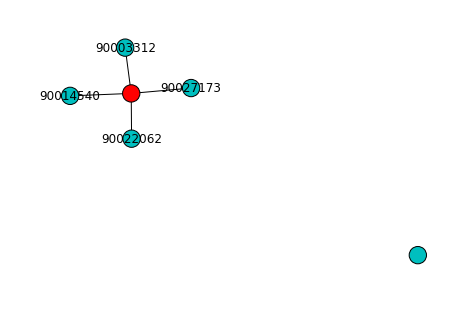

In [98]:
# Creating Networks Objects 

#Imports that should really be at the top of the notebook 
import networkx as nx
# Allows plots to be showed inline 
%matplotlib inline
# Matplotlib is the default package for
# rendering the graphs
import matplotlib.pyplot as plt

# Create the Networkx Graph 
G=nx.Graph()

# Distonarys to contain colors and labels
# Not nessasary
custom_node_color = {}
custom_labels     = {}

#Create the networkx award node 
award_node = G.add_node(specific_award_node[0])
custom_node_color[specific_award_node[0]] = 'r'

#Create networkx nodes for the employees that worked on that node 
for item in associated_employees:
    G.add_node(item)
    custom_node_color[item] = 'c'
    custom_labels[item] = str(item)
    # We know at each of these employees are connected to the award, so lets draw those relationshipd 
    # Note, in Networkx relationships are called edges 
    G.add_edge(item, award_node)
    

print G.nodes()
nx.draw(G,labels=custom_labels, node_color=custom_node_color.values())
plt.show()


# Idk why we always get a bonus None node, i like to thnk of it as a gift 

In [ ]:
import igraph;print igraph.__version__

igraph.plot([(1, 2), (2, 3), (3, 4), (4, 1), (4, 5), (5, 2)])

In [ ]:
cursor.close()

# close connection
db.close()